## 0. Setup

In [1]:
import os, sys, json, platform
from datetime import datetime, timezone
import pandas as pd
import random as rd
import numpy as np
from scipy import stats
import subprocess
import csv
import time
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

### Configuration & Persistence
This notebook is designed to generate `data.csv` and `functions.txt` only once and reuse them across runs.
- On Google Colab, we mount Drive and save files under `BASE_DIR`.
- On a local run, files are stored under the repository's `data/` folder.
- Change only the parameters in the next cell (`N`, `FEATURES`, `SEED`) to trigger regeneration.
- A `gen_meta.json` file records the parameters used to create the current dataset.


In [2]:
!nvidia-smi

Tue Dec 16 21:44:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
print("Mounting Google Drive...")
drive.mount('/content/drive')
BASE_DIR = '/content/drive/My Drive/GP_GPU_acceleration'
print("Drive mounted. BASE_DIR =", BASE_DIR)

os.makedirs(BASE_DIR, exist_ok=True)

Mounting Google Drive...
Mounted at /content/drive
Drive mounted. BASE_DIR = /content/drive/My Drive/GP_GPU_acceleration


In [4]:
# Configuration and persistence (run-once data generation)
# - If running in Google Colab, mount Drive and use a persistent data folder.
# - Generate data only when N/FEATURES change; otherwise reuse existing files.

# User-tunable parameters
N = 100000
FEATURES = 15
SEED = 42

DATA_DIR = os.path.join(BASE_DIR, 'data')
os.makedirs(DATA_DIR, exist_ok=True)

CSV_PATH = os.path.join(DATA_DIR, 'data.csv')
FUNCS_PATH = os.path.join(DATA_DIR, 'functions.txt')
META_PATH = os.path.join(DATA_DIR, 'gen_meta.json')

print("Data directory:", DATA_DIR)
print("CSV path:", CSV_PATH)
print("Functions path:", FUNCS_PATH)

# Helper to decide whether generation is needed
def needs_regeneration(n: int, features: int, seed: int = 42) -> bool:
    if not (os.path.exists(CSV_PATH) and os.path.exists(FUNCS_PATH) and os.path.exists(META_PATH)):
        return True
    try:
        with open(META_PATH, 'r') as f:
            meta = json.load(f)
        return not (meta.get('N') == n and meta.get('FEATURES') == features and meta.get('SEED') == seed)
    except Exception:
        return True

# Save metadata describing current generation
def write_meta(n: int, features: int, seed: int):
    meta = {
        'N': n,
        'FEATURES': features,
        'SEED': seed,
        'timestamp': datetime.now(timezone.utc).isoformat(),
        'paths': {'csv': CSV_PATH, 'functions': FUNCS_PATH}
    }
    with open(META_PATH, 'w') as f:
        json.dump(meta, f, indent=2)

Data directory: /content/drive/My Drive/GP_GPU_acceleration/data
CSV path: /content/drive/My Drive/GP_GPU_acceleration/data/data.csv
Functions path: /content/drive/My Drive/GP_GPU_acceleration/data/functions.txt


In [5]:
# Helper to get GPU metrics (Temperature, Power)
def get_gpu_metrics():
    try:
        # Returns (temperature, power_draw)
        res = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=temperature.gpu,power.draw", "--format=csv,noheader,nounits"],
            encoding='utf-8'
        )
        temp, power = res.strip().split(',')
        return float(temp), float(power)
    except Exception:
        return np.nan, np.nan

# Global storage for benchmark runs
benchmark_data = {
    'mode': [],
    'run_id': [],
    'time_s': [],
    'best_score': [],
    'temp_start': [],
    'temp_end': [],
    'power_start': [],
    'power_end': []
}

def record_run(mode, run_id, time_s, best_score, t_start, t_end, p_start, p_end):
    benchmark_data['mode'].append(mode)
    benchmark_data['run_id'].append(run_id)
    benchmark_data['time_s'].append(time_s)
    benchmark_data['best_score'].append(best_score)
    benchmark_data['temp_start'].append(t_start)
    benchmark_data['temp_end'].append(t_end)
    benchmark_data['power_start'].append(p_start)
    benchmark_data['power_end'].append(p_end)

In [6]:
print("Current working directory:", os.getcwd())
try:
    print("Data directory:", DATA_DIR)
    print("CSV exists:", os.path.exists(CSV_PATH))
    print("Functions exists:", os.path.exists(FUNCS_PATH))
    print("Meta exists:", os.path.exists(META_PATH))
except NameError:
    print("Configuration cell not run yet. Please run the configuration cell above.")

Current working directory: /content
Data directory: /content/drive/My Drive/GP_GPU_acceleration/data
CSV exists: True
Functions exists: True
Meta exists: True


## Generate input data

The parameters can be adjusted to increase/decrease the workload.

In [7]:
# Only generate if parameters differ or files are missing
if needs_regeneration(N, FEATURES, SEED):
    print("Generating dataset and functions... (this may take a moment)")
    rd.seed(SEED)
    np.random.seed(SEED)

    cols = "abcdefghijkmnopqrstuv"
    columns = list(cols)[:FEATURES]

    x = np.random.rand(N, FEATURES)
    df = pd.DataFrame(x, columns=columns)
    # Simple target
    df["y"] = np.sin(df["a"].values) + np.cos(df["b"].values) + np.random.rand(N) * 0.001

    # Persist to CSV
    df.to_csv(CSV_PATH, index=False)

    # Program generators
    unary_funs = ["sinf", "cosf", "sqrtf"]
    operators = ["+", "-"]

    def random_program(depth=4):
        r = rd.randint(0, 100)
        if depth == 0 or r < 30:
            c = rd.choice(columns)
            return f"_{c}_"
        elif r < 80:
            c = rd.choice(unary_funs)
            r1 = random_program(depth - 1)
            return f"{c}({r1})"
        else:
            c = rd.choice(operators)
            r1 = random_program(depth - 1)
            r2 = random_program(depth - 1)
            return f"({r1}) {c} ({r2})"

    with open(FUNCS_PATH, "w") as f:
        for _ in range(1000):
            f.write(random_program() + "\n")

    write_meta(N, FEATURES, SEED)
    print("Generation complete. Files written:")
    print("-", CSV_PATH)
    print("-", FUNCS_PATH)
    print("-", META_PATH)
else:
    print("Using existing dataset and functions (no regeneration needed). To regenerate, change N/FEATURES/SEED.")


Using existing dataset and functions (no regeneration needed). To regenerate, change N/FEATURES/SEED.


In [8]:
# Load the persisted dataset
try:
    df = pd.read_csv(CSV_PATH)
    display(df.head())
    # print(df.info())
    # print(df.describe())
    print(f"\nDataframe shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
except Exception as e:
    raise RuntimeError(f"Failed to read CSV at {CSV_PATH}: {e}")

,a,b,c,d,e,f,g,h,i,j,k,m,n,o,p,y
0,0.374540,0.950714,0.731994,0.598658,0.156019,0.155995,0.058084,0.866176,0.601115,0.708073,0.020584,0.969910,0.832443,0.212339,0.181825,0.947665
1,0.183405,0.304242,0.524756,0.431945,0.291229,0.611853,0.139494,0.292145,0.366362,0.456070,0.785176,0.199674,0.514234,0.592415,0.046450,1.136877
2,0.607545,0.170524,0.065052,0.948886,0.965632,0.808397,0.304614,0.097672,0.684233,0.440152,0.122038,0.495177,0.034389,0.909320,0.258780,1.556550
3,0.662522,0.311711,0.520068,0.546710,0.184854,0.969585,0.775133,0.939499,0.894827,0.597900,0.921874,0.088493,0.195983,0.045227,0.325330,1.567014
4,0.388677,0.271349,0.828738,0.356753,0.280935,0.542696,0.140924,0.802197,0.074551,0.986887,0.772245,0.198716,0.005522,0.815461,0.706857,1.343070



Dataframe shape: 100,000 rows x 16 columns


## Run sequential version

In [9]:
# Load functions once
try:
    funs = [line.strip() for line in open(FUNCS_PATH).readlines()]
except Exception as e:
    raise RuntimeError(f"Failed to read functions at {FUNCS_PATH}: {e}")

def score(line):
    # Use np.emath.sqrt to handle negative inputs by returning complex numbers
    line = line.replace("sqrtf", "np.emath.sqrt")

    # Replace other unary functions with their NumPy equivalents
    for u in ["sinf", "cosf", "tanf", "expf"]:
        line = line.replace(u, f"np.{u[:-1]}")

    # Replace column placeholders with actual DataFrame column values
    for c in df.columns:
        line = line.replace(f"_{c}_", f"(df[\"{c}\"].values)")

    # Evaluate the expression
    try:
        a = eval(line)
        b = df["y"]
        # Mean squared error (supports complex via magnitude/absolute difference)
        e = np.mean(np.abs(a - b)**2)
        return e
    except Exception:
        return float('inf')

# --- Sequential Benchmark Loop ---
N_RUNS = 30
print(f"Running Sequential CPU Benchmark ({N_RUNS} runs)...")

seq_times = []
best_seq_score = float('inf')
best_seq_func = ""

for i in range(N_RUNS):
    t_start, p_start = get_gpu_metrics()

    t0 = time.perf_counter()
    # Evaluate all functions
    current_scores = [(score(line), line) for line in funs]
    t1 = time.perf_counter()

    t_end, p_end = get_gpu_metrics()

    duration = t1 - t0
    seq_times.append(duration)

    # Track best
    current_scores.sort()
    run_best_score = current_scores[0][0]
    if run_best_score < best_seq_score:
        best_seq_score = run_best_score
        best_seq_func = current_scores[0][1]

    record_run("Sequential CPU", i, duration, run_best_score, t_start, t_end, p_start, p_end)

    print(f"Run {i+1}/{N_RUNS}: {duration:.4f}s", end='\r')

print(f"\nSequential CPU Mean Time: {np.mean(seq_times):.4f} s (std: {np.std(seq_times):.4f})")
print(f"Best score (smallest MSE): {best_seq_score}")
print(f"Best Function: {best_seq_func}")

Running Sequential CPU Benchmark (30 runs)...
Run 30/30: 2.7841s
Sequential CPU Mean Time: 2.7813 s (std: 0.0158)
Best score (smallest MSE): 0.059034244888362994
Best Function: sqrtf(((cosf(_i_)) + ((_a_) - (_f_))) + (cosf(sqrtf(_o_))))


## GPU Acceleration Implementations

The following sections implement the GPU acceleration strategies discussed in the report:
1. **Naive CuPy**: High-level Python implementation using CuPy arrays.
2. **Mega-Kernel**: Low-level CUDA implementation using CuPy's `RawKernel` with dynamic code generation.

In [10]:
try:
    import cupy as cp
    # Try to access the driver to check availability
    device_count = cp.cuda.runtime.getDeviceCount()
    gpu_available = (device_count > 0)
    print(f"CuPy is available. GPU device(s): {device_count}")

    gpu_name = "Unknown"
    # Print device info
    if gpu_available:
        props = cp.cuda.runtime.getDeviceProperties(0)
        gpu_name = props['name'].decode('utf-8')
        print(f"Device 0: {gpu_name}")

except Exception as e:
    cp = None
    gpu_available = False
    gpu_name = "None"
    print("CuPy/CUDA not available:", e)
    print("Running in CPU-only mode.")

CuPy is available. GPU device(s): 1
Device 0: NVIDIA A100-SXM4-40GB


In [11]:
if 'cp' in globals() and cp is not None and gpu_available:
    # Prepare data for GPU (Column-Major / Fortran Order)
    features = [c for c in df.columns if c != 'y']

    # Transfer to GPU
    data_gpu = cp.asarray(df[features].values, order='F', dtype=cp.float32)
    y_gpu = cp.asarray(df['y'].values, dtype=cp.float32)

    n_rows, n_cols = data_gpu.shape
    print(f"GPU Data Shape: {data_gpu.shape}")
else:
    print("Skipping GPU data prep: CuPy/CUDA not available.")

GPU Data Shape: (100000, 15)


In [12]:
if 'cp' in globals() and cp is not None and gpu_available:
    def score_cupy_naive(line):
        # Define protected sqrt to match Mega-Kernel (sqrt(abs(x)))
        # Using a helper function avoids parenthesis balancing issues with string replacement
        def p_sqrt(x):
            return cp.sqrt(cp.abs(x))

        # Replace functions with CuPy equivalents
        # Replace 'sqrtf' with 'p_sqrt' (function call), preserving parentheses
        line = line.replace("sqrtf", "p_sqrt")
        for u in ["sinf", "cosf", "tanf", "expf"]:
            line = line.replace(u, f"cp.{u[:-1]}")

        # Replace variables with GPU array slices
        for i, c in enumerate([c for c in df.columns if c != 'y']):
            line = line.replace(f"_{c}_", f"data_gpu[:, {i}]")

        try:
            # Evaluate with local context (p_sqrt is captured)
            a = eval(line)
            e = cp.mean((a - y_gpu)**2)
            return float(e.get())
        except Exception:
            return float('inf')

    print(f"Running Naive CuPy Benchmark ({N_RUNS} runs)...")
    naive_times = []
    best_naive_score = float('inf')
    best_naive_func = ""

    # Warmup
    score_cupy_naive(funs[0])

    for i in range(N_RUNS):
        cp.cuda.Stream.null.synchronize()
        t_start, p_start = get_gpu_metrics()

        t0 = time.perf_counter()
        scores_naive = [score_cupy_naive(l) for l in funs]
        cp.cuda.Stream.null.synchronize()
        t1 = time.perf_counter()

        t_end, p_end = get_gpu_metrics()

        duration = t1 - t0
        naive_times.append(duration)

        # Track best
        run_best_score = min(scores_naive)
        if run_best_score < best_naive_score:
            best_naive_score = run_best_score
            # Find index of best score to get function string
            best_idx = scores_naive.index(run_best_score)
            best_naive_func = funs[best_idx]

        record_run("Naive CuPy", i, duration, run_best_score, t_start, t_end, p_start, p_end)
        print(f"Run {i+1}/{N_RUNS}: {duration:.4f}s", end='\r')

    naive_time_s = np.mean(naive_times)
    print(f"\nNaive CuPy Mean Time: {naive_time_s:.4f} s (std: {np.std(naive_times):.4f})")
    print(f"Best score (smallest MSE): {best_naive_score}")
    print(f"Best Function: {best_naive_func}")
else:
    naive_time_s = None
    print("Skipping Naive CuPy Benchmark: GPU unavailable.")

Running Naive CuPy Benchmark (30 runs)...
Run 30/30: 0.3524s
Naive CuPy Mean Time: 0.3670 s (std: 0.0572)
Best score (smallest MSE): 0.05903424322605133
Best Function: sqrtf(((cosf(_i_)) + ((_a_) - (_f_))) + (cosf(sqrtf(_o_))))


--- Tuning Mega-Kernel Parameters ---
Batch size candidates: [32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448, 480, 512]
Testing Batch Size: 32... Exec Time: 1.7757e-02 s  Compile Time: 24.13 s
Testing Batch Size: 64... Exec Time: 9.9378e-03 s  Compile Time: 26.47 s
Testing Batch Size: 96... Exec Time: 7.4324e-03 s  Compile Time: 29.28 s
Testing Batch Size: 128... Exec Time: 5.5808e-03 s  Compile Time: 35.63 s
Testing Batch Size: 160... Exec Time: 5.0801e-03 s  Compile Time: 39.69 s
Testing Batch Size: 192... Exec Time: 4.4056e-03 s  Compile Time: 46.02 s
Testing Batch Size: 224... Exec Time: 3.9411e-03 s  Compile Time: 47.25 s
Testing Batch Size: 256... Exec Time: 3.2716e-03 s  Compile Time: 58.16 s
Testing Batch Size: 288... Exec Time: 3.5400e-03 s  Compile Time: 60.74 s
Testing Batch Size: 320... Exec Time: 3.1673e-03 s  Compile Time: 70.86 s
Testing Batch Size: 352... Exec Time: 2.9635e-03 s  Compile Time: 74.21 s
Testing Batch Size: 384... Exec Time: 2.9935e-03 s

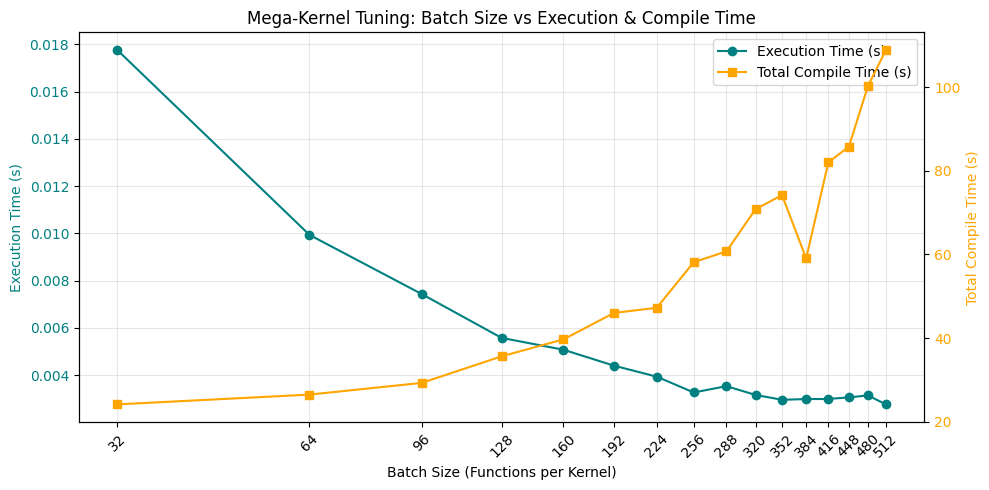

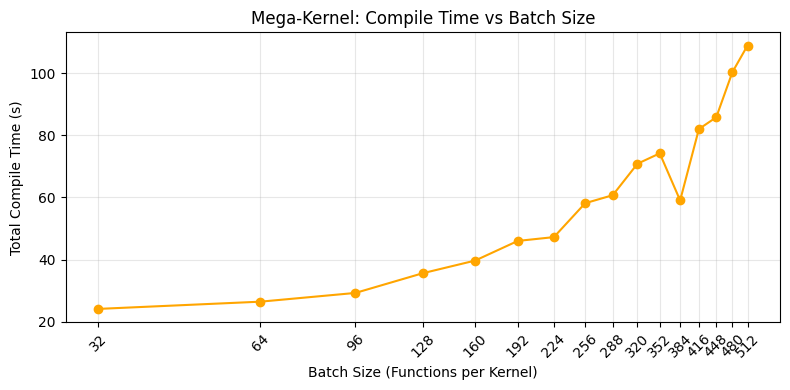

Compile-time curve saved to: /content/drive/My Drive/GP_GPU_acceleration/data/tuning_compile_curve.png
Compiling final kernels with Batch Size 512...
Compilation complete in 5.7736e-04s (Fast if cached)
Running Mega-Kernel Benchmark (30 runs)...
Run 30/30: 2.3744e-03s
Mega-Kernel Mean Exec Time: 2.3647e-03 s (std: 1.2444e-05)
Best score (smallest MSE): 0.05903424322605133
Best Function: sqrtf(((cosf(_i_)) + ((_a_) - (_f_))) + (cosf(sqrtf(_o_))))


In [13]:
if 'cp' in globals() and cp is not None and gpu_available:
    # --- Architectural Decisions (Addressing Assignment Questions) ---
    # 1. Parallelization Strategy:
    #    - Grid y-dimension maps to Functions (Task Parallelism).
    #    - Grid x-dimension and Threads map to Data Rows (Data Parallelism).
    # 2. Minimizing Kernels:
    #    - We use "Kernel Fusion" via the switch-case statement to batch multiple functions into a single kernel launch.
    # 3. Minimizing Data Transfers:
    #    - Data is copied to GPU once (`data_gpu`, `y_gpu`) and reused for all generations.
    # 4. Shared Memory:
    #    - Used for parallel reduction (summing squared errors) within a block to reduce global memory atomic collisions.
    # 5. Branch Conflicts (Divergence):
    #    - Crucial Design: We switch on `func_idx` which is `blockIdx.y`.
    #    - Since all threads in a block (and thus in a warp) share the same `blockIdx.y`, they all take the SAME branch.
    #    - This eliminates warp divergence for the function logic.

    # 1. Transpiler
    def transpile_to_cuda(line, features):
        for i, c in enumerate(features):
            line = line.replace(f"_{c}_", f"data[idx + {i} * n_rows]")
        line = line.replace("sqrtf", "p_sqrtf")
        return line

    features = [c for c in df.columns if c != 'y']
    transpiled_funs = [transpile_to_cuda(f, features) for f in funs]

    kernel_code_template = r'''
    __device__ inline float p_sqrtf(float x) { return sqrtf(fabsf(x)); }

    extern "C" __global__
    void evaluate_population(const float* data, const float* y_true, float* fitness_scores, int n_rows) {
        int func_idx = blockIdx.y;
        int tid = threadIdx.x;
        float error_sum = 0.0f;

        for (int idx = tid; idx < n_rows; idx += blockDim.x) {
            float y_pred = 0.0f;
            switch(func_idx) {
                PLACEHOLDER_CASES
            }
            float diff = y_pred - y_true[idx];
            error_sum += diff * diff;
        }

        __shared__ float sdata[256];
        sdata[tid] = error_sum;
        __syncthreads();

        for (unsigned int s = blockDim.x / 2; s > 0; s >>= 1) {
            if (tid < s) {
                sdata[tid] += sdata[tid + s];
            }
            __syncthreads();
        }

        if (tid == 0) {
            fitness_scores[func_idx + BLOCK_OFFSET] = sdata[0] / n_rows;
        }
    }
    '''

    # --- Step 1: Extensive Dynamic Parameter Tuning ---
    print("--- Tuning Mega-Kernel Parameters ---")
    # Expanded range to see the "U-shape" trade-off
    candidate_batch_sizes = [32 * n for n in range(1, 17)]  # test 32..512
    print(f"Batch size candidates: {candidate_batch_sizes}")
    tuning_batches = []
    tuning_exec_times = []
    tuning_compile_times = []
    best_batch_size = 32
    best_exec_time = float('inf')

    for b_size in candidate_batch_sizes:
        print(f"Testing Batch Size: {b_size}...", end=" ")
        try:
            # Prepare the transpiled batches
            batches_test = [transpiled_funs[i:i + b_size] for i in range(0, len(transpiled_funs), b_size)]
            kernels_test = []
            # Measure compile time (total for all kernels in this candidate)
            total_compile_time = 0.0
            compile_failed = False
            for batch_idx, batch in enumerate(batches_test):
                cases_code = "".join([f"case {i}: y_pred = {code}; break;\n" for i, code in enumerate(batch)])
                code = kernel_code_template.replace("PLACEHOLDER_CASES", cases_code).replace("BLOCK_OFFSET", str(batch_idx * b_size))
                k = cp.RawKernel(code, 'evaluate_population')
                tc0 = time.perf_counter()
                try:
                    k.compile()
                except Exception as e:
                    # record failure and abort this candidate
                    print(f" compile-failed: {e}")
                    compile_failed = True
                    break
                tc1 = time.perf_counter()
                total_compile_time += (tc1 - tc0)
                kernels_test.append((k, len(batch)))

            if compile_failed:
                tuning_batches.append(b_size)
                tuning_exec_times.append(np.nan)
                tuning_compile_times.append(np.nan)
                continue
            # Execute and measure runtime
            cp.cuda.Stream.null.synchronize()
            t0 = time.perf_counter()
            temp_scores = cp.zeros(len(funs), dtype=cp.float32)
            for k, l in kernels_test:
                k((1, l), (256,), (data_gpu, y_gpu, temp_scores, data_gpu.shape[0]))
            cp.cuda.Stream.null.synchronize()
            t1 = time.perf_counter()

            exec_t = t1 - t0
            print(f"Exec Time: {exec_t:.4e} s  Compile Time: {total_compile_time:.4} s")

            tuning_batches.append(b_size)
            tuning_exec_times.append(exec_t)
            tuning_compile_times.append(total_compile_time)

            if exec_t < best_exec_time:
                best_exec_time = exec_t
                best_batch_size = b_size
        except Exception as e:
            print(f"Failed (likely register pressure or code size limit): {e}")

    print(f"Optimal Batch Size Selected (by exec time): {best_batch_size}")
    BATCH_SIZE = best_batch_size
    # Plot Tuning Curve (Execution vs Compile time)
    plt.figure(figsize=(10, 5))
    ax1 = plt.gca()
    ax1.plot(tuning_batches, tuning_exec_times, marker='o', color='teal', label='Execution Time (s)')
    ax1.set_xscale('log', base=2)
    ax1.set_xlabel("Batch Size (Functions per Kernel)")
    ax1.set_ylabel("Execution Time (s)", color='teal')
    ax1.tick_params(axis='y', labelcolor='teal')
    ax1.set_xticks(tuning_batches)
    ax1.set_xticklabels(tuning_batches, rotation=45)

    ax2 = ax1.twinx()
    ax2.plot(tuning_batches, tuning_compile_times, marker='s', color='orange', label='Total Compile Time (s)')
    ax2.set_ylabel("Total Compile Time (s)", color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    plt.title("Mega-Kernel Tuning: Batch Size vs Execution & Compile Time")
    ax1.grid(True, alpha=0.3)
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.tight_layout()
    tuning_path = os.path.join(DATA_DIR, 'tuning_curve.png')
    plt.savefig(tuning_path)
    print(f"Tuning curve saved to: {tuning_path}")
    plt.show()

    # Also save compile-only plot (linear y)
    plt.figure(figsize=(8, 4))
    plt.plot(tuning_batches, tuning_compile_times, marker='o', linestyle='-', color='orange')
    plt.xscale('log', base=2)
    plt.xlabel("Batch Size (Functions per Kernel)")
    plt.ylabel("Total Compile Time (s)")
    plt.title("Mega-Kernel: Compile Time vs Batch Size")
    plt.grid(True, alpha=0.3)
    plt.xticks(tuning_batches, tuning_batches, rotation=45)
    compile_plot_path = os.path.join(DATA_DIR, 'tuning_compile_curve.png')
    plt.tight_layout()
    plt.savefig(compile_plot_path)
    plt.show()
    print(f"Compile-time curve saved to: {compile_plot_path}")

    # --- Step 2: Final Compilation ---
    print(f"Compiling final kernels with Batch Size {BATCH_SIZE}...")
    batches = [transpiled_funs[i:i + BATCH_SIZE] for i in range(0, len(transpiled_funs), BATCH_SIZE)]
    compiled_kernels = []

    # Note: If kernels were compiled in the tuning loop, this will be fast (cache hit)
    t_compile_start = time.perf_counter()
    for batch_idx, batch in enumerate(batches):
        cases_code = "".join([f"case {i}: y_pred = {code}; break;\n" for i, code in enumerate(batch)])
        code = kernel_code_template.replace("PLACEHOLDER_CASES", cases_code).replace("BLOCK_OFFSET", str(batch_idx * BATCH_SIZE))
        k = cp.RawKernel(code, 'evaluate_population')
        k.compile()
        compiled_kernels.append((k, len(batch)))
    cp.cuda.Stream.null.synchronize()
    compilation_time = time.perf_counter() - t_compile_start
    print(f"Compilation complete in {compilation_time:.4e}s (Fast if cached)")

    # --- Step 3: Statistical Benchmarking Loop ---
    print(f"Running Mega-Kernel Benchmark ({N_RUNS} runs)...")
    mega_times = []
    all_scores_mk = cp.zeros(len(funs), dtype=cp.float32)

    for i in range(N_RUNS):
        cp.cuda.Stream.null.synchronize()
        t_start, p_start = get_gpu_metrics()

        t0 = time.perf_counter()
        for kernel, batch_len in compiled_kernels:
            kernel((1, batch_len), (256,), (data_gpu, y_gpu, all_scores_mk, data_gpu.shape[0]))
        cp.cuda.Stream.null.synchronize()
        t1 = time.perf_counter()

        t_end, p_end = get_gpu_metrics()

        duration = t1 - t0
        mega_times.append(duration)

        run_best_score = float(cp.min(all_scores_mk).get())
        record_run("Mega-Kernel GPU", i, duration, run_best_score, t_start, t_end, p_start, p_end)
        print(f"Run {i+1}/{N_RUNS}: {duration:.4e}s", end='\r')

    mega_time_s = np.mean(mega_times)
    print(f"\nMega-Kernel Mean Exec Time: {mega_time_s:.4e} s (std: {np.std(mega_times):.4e})")

    # Best Score
    best_idx = int(cp.argmin(all_scores_mk).get())
    best_score_mk = float(all_scores_mk[best_idx].get())
    print(f"Best score (smallest MSE): {best_score_mk}")
    print(f"Best Function: {funs[best_idx]}")

else:
    mega_time_s = None
    print("Skipping Mega-Kernel Benchmark: GPU unavailable.")

Benchmark data saved to: /content/drive/My Drive/GP_GPU_acceleration/data/benchmark_results.csv

--- Statistical Analysis ---
Statistical Significance (Mann-Whitney U):


,Comparison,Mean 1,Mean 2,p-value,Significant
0,Sequential CPU vs Naive CuPy,2.7813,0.3670,3.0199e-11,Yes
1,Sequential CPU vs Mega-Kernel GPU,2.7813,0.0024,3.0199e-11,Yes
2,Naive CuPy vs Mega-Kernel GPU,0.3670,0.0024,3.0199e-11,Yes


LaTeX table saved to: /content/drive/My Drive/GP_GPU_acceleration/data/mann_whitney_stats.tex

--- Speedup Analysis ---


,Mode,Time (s),Speedup (x)
0,Sequential CPU,2.7813 ± 0.0160,1.00 ± 0.00
1,Naive CuPy,0.3670 ± 0.0582,7.58 ± 1.20
2,Mega-Kernel GPU,(2.36 ± 0.01)e-3,1176.17 ± 9.26


LaTeX table saved to: /content/drive/My Drive/GP_GPU_acceleration/data/speedup_summary.tex

--- Consistency Check ---
Minimum MSE achieved per mode:
mode
Mega-Kernel GPU    0.059034
Naive CuPy         0.059034
Sequential CPU     0.059034
Name: best_score, dtype: float64

[OK] Best scores (MSE) are consistent across all modes.

--- Best Function Verification ---
Functions found (3 modes):
  Sequential CPU: sqrtf(((cosf(_i_)) + ((_a_) - (_f_))) + (cosf(sqrtf(_o_))))
  Naive CuPy: sqrtf(((cosf(_i_)) + ((_a_) - (_f_))) + (cosf(sqrtf(_o_))))
  Mega-Kernel GPU: sqrtf(((cosf(_i_)) + ((_a_) - (_f_))) + (cosf(sqrtf(_o_))))

[OK] Best function string is identical across all recorded modes.
Plot saved to: /content/drive/My Drive/GP_GPU_acceleration/data/benchmark_plot.png


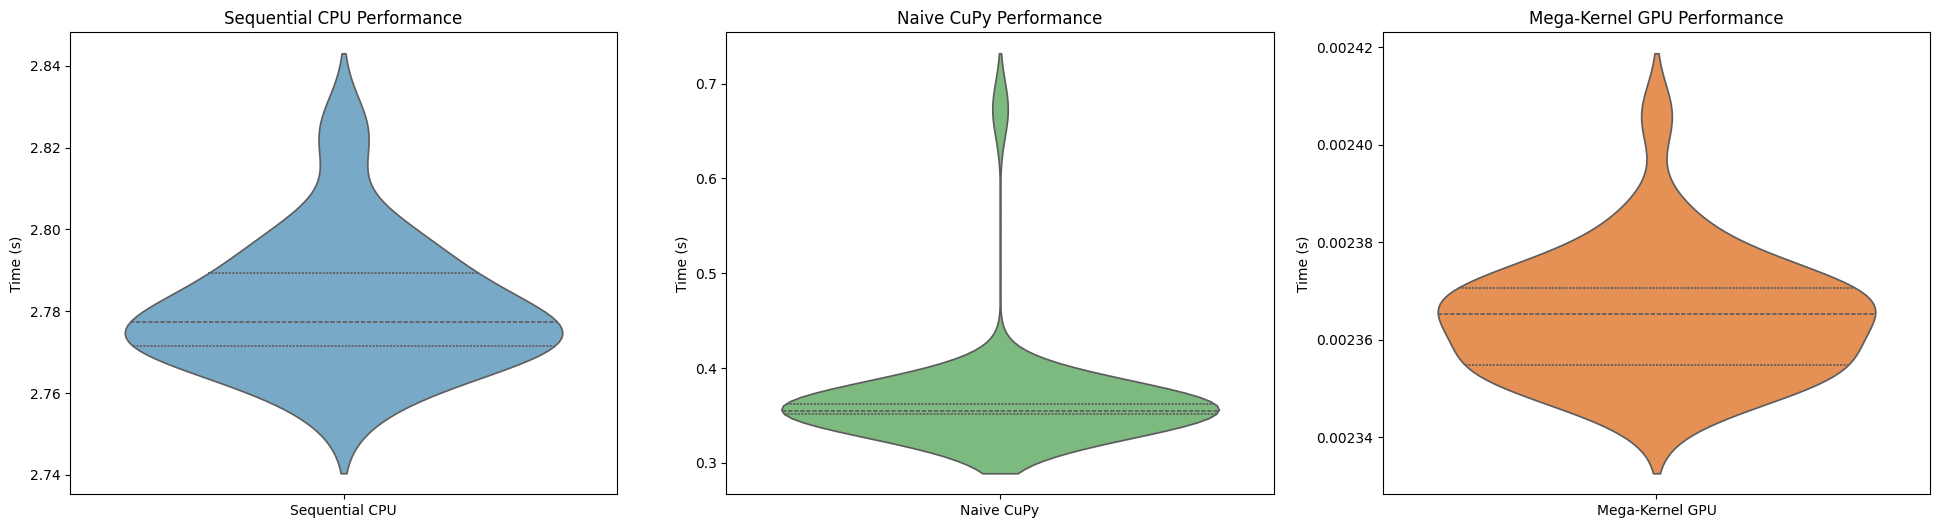


--- GPU Metrics Analysis ---


,Mode,Start Temp (C),Temp Variation (C),Mean Power (W)
0,Sequential CPU,30.0 ± 0.0,0.0 ± 0.0,44.7 ± 0.0
1,Naive CuPy,30.0 ± 0.0,0.0 ± 0.0,51.7 ± 0.2
2,Mega-Kernel GPU,30.7 ± 0.4,0.0 ± 0.5,52.7 ± 1.5


LaTeX table saved to: /content/drive/My Drive/GP_GPU_acceleration/data/gpu_metrics_table.tex
Summary JSON saved.


In [28]:
# Analysis, Visualization, and Persistence
# Helper to save LaTeX tables
def save_latex_table(df, filename, caption):
    path = os.path.join(DATA_DIR, filename)
    # Escape special characters for LaTeX if necessary, though simple numbers are fine
    try:
        latex_code = df.to_latex(index=False, caption=caption, column_format='|'.join(['l']*len(df.columns)))
        with open(path, 'w') as f:
            f.write(latex_code)
        print(f"LaTeX table saved to: {path}")
    except AttributeError:
        # Fallback for very new pandas versions where to_latex might be removed/moved
        print(f"Could not save LaTeX to {path} (method might be deprecated).")

# 1. Save Raw Benchmark Data to CSV
df_bench = pd.DataFrame(benchmark_data)
BENCH_CSV_PATH = os.path.join(DATA_DIR, 'benchmark_results.csv')
df_bench.to_csv(BENCH_CSV_PATH, index=False)
print(f"Benchmark data saved to: {BENCH_CSV_PATH}")

# 2. Statistical Analysis
print("\n--- Statistical Analysis ---")
modes = df_bench['mode'].unique()
stats_results = []

for i in range(len(modes)):
    for j in range(i + 1, len(modes)):
        m1 = modes[i]
        m2 = modes[j]
        data1 = df_bench[df_bench['mode'] == m1]['time_s']
        data2 = df_bench[df_bench['mode'] == m2]['time_s']

        stat, p_val = stats.mannwhitneyu(data1, data2)
        stats_results.append({
            'Comparison': f"{m1} vs {m2}",
            'Mean 1': f"{data1.mean():.4f}",
            'Mean 2': f"{data2.mean():.4f}",
            'p-value': f"{p_val:.4e}",
            'Significant': "Yes" if p_val < 0.05 else "No"
        })

df_stats = pd.DataFrame(stats_results)
print("Statistical Significance (Mann-Whitney U):")
display(df_stats)
save_latex_table(df_stats, 'mann_whitney_stats.tex', 'Statistical Significance of Execution Times')

# 3. Speedup Analysis
print("\n--- Speedup Analysis ---")
cpu_series = df_bench[df_bench['mode'] == 'Sequential CPU']['time_s']
cpu_mean = cpu_series.mean()
cpu_std = cpu_series.std()

speedup_rows = []

for m in modes:
    # Include all modes, even CPU
    times = df_bench[df_bench['mode'] == m]['time_s']
    mean_t = times.mean()
    std_t = times.std()

    # Get best score stats
    scores = df_bench[df_bench['mode'] == m]['best_score']

    # 1. Calculate Speedup (Mean CPU / Mean Mode)
    if m == 'Sequential CPU':
        speedup_mean = 1.0
        speedup_std = 0.0
    else:
        speedup_mean = cpu_mean / mean_t
        # Error Propagation:
        speedup_std = speedup_mean * np.sqrt((cpu_std/cpu_mean)**2 + (std_t/mean_t)**2)

    # 2. Format Time: Use scientific notation for small values (e.g. < 0.01s)
    if mean_t < 0.01 and mean_t > 0:
        # Calculate exponent for scientific notation
        exp = int(np.floor(np.log10(mean_t)))
        norm_mean = mean_t / (10**exp)
        norm_std = std_t / (10**exp)
        time_str = f"({norm_mean:.2f} ± {norm_std:.2f})e{exp}"
    else:
        time_str = f"{mean_t:.4f} ± {std_t:.4f}"

    # Format as Mean ± Std
    row = {
        'Mode': m,
        'Time (s)': time_str,
        'Speedup (x)': f"{speedup_mean:.2f} ± {speedup_std:.2f}"
    }
    speedup_rows.append(row)

df_speedup_summary = pd.DataFrame(speedup_rows)
display(df_speedup_summary)
save_latex_table(df_speedup_summary, 'speedup_summary.tex', 'Performance Speedup and Accuracy')

# Consistency Check
print("\n--- Consistency Check ---")

# 1. Check MSE
best_scores_min = df_bench.groupby('mode')['best_score'].min()
print("Minimum MSE achieved per mode:")
print(best_scores_min)

if len(best_scores_min) > 1:
    baseline_score = best_scores_min.iloc[0]
    # Use a small tolerance for float comparison
    is_score_consistent = np.allclose(best_scores_min.values, baseline_score, rtol=1e-4)
    if is_score_consistent:
        print("\n[OK] Best scores (MSE) are consistent across all modes.")
    else:
        print("\n[WARNING] Best scores differ across modes! Check precision or implementation.")
else:
    print("\nOnly one mode run, cannot check score consistency.")

# 2. Check Best Functions
print("\n--- Best Function Verification ---")
best_funcs_found = {}

# Retrieve from globals if available
if 'best_seq_func' in globals():
    best_funcs_found['Sequential CPU'] = best_seq_func

if 'best_naive_func' in globals():
    best_funcs_found['Naive CuPy'] = best_naive_func

# For Mega-Kernel, we rely on best_idx from the last run of that cell
if 'best_idx' in globals() and 'funs' in globals() and 'all_scores_mk' in globals():
    # Verify if Mega-Kernel was actually one of the modes in the dataframe
    if 'Mega-Kernel GPU' in df_bench['mode'].unique():
        best_funcs_found['Mega-Kernel GPU'] = funs[best_idx]

if len(best_funcs_found) > 0:
    print(f"Functions found ({len(best_funcs_found)} modes):")
    for mode, func in best_funcs_found.items():
        print(f"  {mode}: {func}")

    # Check consistency
    unique_funcs = set(best_funcs_found.values())
    if len(unique_funcs) == 1:
        print("\n[OK] Best function string is identical across all recorded modes.")
    else:
        print("\n[WARNING] Best functions differ across modes!")
else:
    print("No function strings found in global variables (did you run the benchmarks?).")

# 4. Visualization (Performance Only)
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Plot 1: Sequential CPU
sns.violinplot(data=df_bench[df_bench['mode'] == 'Sequential CPU'], x='mode', y='time_s', hue='mode', ax=axes[0], palette='Blues', inner='quartile', legend=False)
axes[0].set_title("Sequential CPU Performance")
axes[0].set_ylabel("Time (s)")
axes[0].set_xlabel("")

# Plot 2: Naive CuPy
naive_data = df_bench[df_bench['mode'] == 'Naive CuPy']
if not naive_data.empty:
    sns.violinplot(data=naive_data, x='mode', y='time_s', hue='mode', ax=axes[1], palette='Greens', inner='quartile', legend=False)
    axes[1].set_title("Naive CuPy Performance")
    axes[1].set_ylabel("Time (s)")
    axes[1].set_xlabel("")
else:
    axes[1].text(0.5, 0.5, "No Naive CuPy Data", ha='center')

# Plot 3: Mega-Kernel GPU
mega_data = df_bench[df_bench['mode'] == 'Mega-Kernel GPU']
if not mega_data.empty:
    sns.violinplot(data=mega_data, x='mode', y='time_s', hue='mode', ax=axes[2], palette='Oranges', inner='quartile', legend=False)
    axes[2].set_title("Mega-Kernel GPU Performance")
    axes[2].set_ylabel("Time (s)")
    axes[2].set_xlabel("")
else:
    axes[2].text(0.5, 0.5, "No Mega-Kernel Data", ha='center')

PLOT_PATH = os.path.join(DATA_DIR, 'benchmark_plot.png')
plt.savefig(PLOT_PATH)
print(f"Plot saved to: {PLOT_PATH}")
plt.show()

# 5. Temperature & Power Analysis
print("\n--- GPU Metrics Analysis ---")
# Calculate deltas
df_bench['temp_delta'] = df_bench['temp_end'] - df_bench['temp_start']
df_bench['power_mean'] = (df_bench['power_start'] + df_bench['power_end']) / 2

# Filter for GPU modes (assuming CPU doesn't report nvidia-smi metrics usually, or we want to focus on GPU load)
# Actually, the code records GPU metrics even during CPU runs (as baseline). Let's show all.
metrics_rows = []

for m in modes:
    subset = df_bench[df_bench['mode'] == m]
    # Check if we actually have valid metrics (not all NaNs)
    if subset['temp_start'].isnull().all():
        continue

    row = {
        'Mode': m,
        'Start Temp (C)': f"{subset['temp_start'].mean():.1f} ± {subset['temp_start'].std():.1f}",
        'Temp Variation (C)': f"{subset['temp_delta'].mean():.1f} ± {subset['temp_delta'].std():.1f}",
        'Mean Power (W)': f"{subset['power_mean'].mean():.1f} ± {subset['power_mean'].std():.1f}"
    }
    metrics_rows.append(row)

if metrics_rows:
    df_metrics = pd.DataFrame(metrics_rows)
    display(df_metrics)
    save_latex_table(df_metrics, 'gpu_metrics_table.tex', 'GPU Environmental Metrics (Mean ± Std)')
else:
    print("No valid GPU metrics available (nvidia-smi might be missing).")

# 6. Save Summary JSON
RESULTS_PATH = os.path.join(DATA_DIR, 'results.json')
summary_results = {
    'N': N,
    'FEATURES': FEATURES,
    'python': platform.python_version(),
    'gpu_available': bool(gpu_available) if 'gpu_available' in globals() else False,
    'gpu_name': gpu_name if 'gpu_name' in globals() else "Unknown",
    'best_batch_size': int(best_batch_size) if 'best_batch_size' in globals() else None,
    'compilation_time_s': float(compilation_time) if 'compilation_time' in globals() else None,
    'modes': {}
}

for m in modes:
    times = df_bench[df_bench['mode'] == m]['time_s']
    scores = df_bench[df_bench['mode'] == m]['best_score']
    summary_results['modes'][m] = {
        'mean_time': float(times.mean()),
        'std_time': float(times.std()),
        'mean_best_score': float(scores.mean()) if not scores.empty else None,
        'min_best_score': float(scores.min()) if not scores.empty else None
    }

with open(RESULTS_PATH, 'w') as f:
    json.dump(summary_results, f, indent=2)
print("Summary JSON saved.")


--- Running Crossover Point Analysis (Scaling N) ---
Testing N=10^2... CPU: 0.0073s, Naive: 0.0121s, Mega: 0.0001s
Testing N=10^3... CPU: 0.0096s, Naive: 0.0120s, Mega: 0.0001s
Testing N=10^4... CPU: 0.0340s, Naive: 0.0121s, Mega: 0.0001s
Testing N=10^5... CPU: 0.2609s, Naive: 0.0122s, Mega: 0.0006s
Testing N=10^6... CPU: 3.4571s, Naive: 0.0127s, Mega: 0.0071s
Testing N=10^7... CPU: Skipped (RAM), Naive: 0.0289s, Mega: 0.0842s
Testing N=10^8... CPU: Skipped (RAM), Naive: 1.1287s, Mega: 0.8269s
Crossover plot saved to: /content/drive/My Drive/GP_GPU_acceleration/data/crossover_plot.png


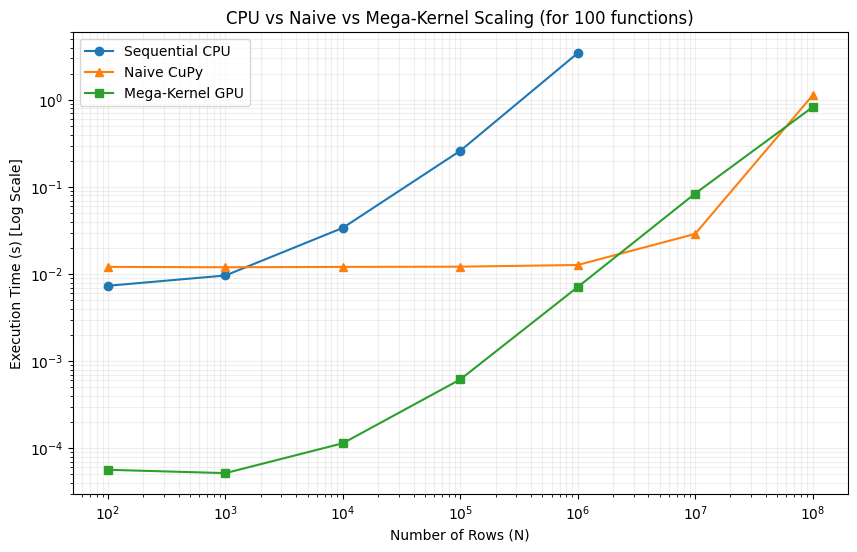

In [15]:
# --- Crossover Point Analysis (Scaling Test) ---
# Question: "After which combination of number of functions and number of rows... does it make sense to use the GPU?"

if 'cp' in globals() and cp is not None and gpu_available:
    print("\n--- Running Crossover Point Analysis (Scaling N) ---")

    # Test parameters
    test_Ns = [10**n for n in range(2, 9)]
    # Use a subset of functions for speed if needed, or all
    test_funcs = funs[:100] # Test with 100 functions to be quick

    cpu_times = []
    naive_times = []
    gpu_times = []

    # Pre-compile GPU kernel for this specific function set size (100)
    # We reuse the best batch size found earlier
    features = [c for c in df.columns if c != 'y']
    transpiled_test = [transpile_to_cuda(f, features) for f in test_funcs]
    batches_test = [transpiled_test[i:i + BATCH_SIZE] for i in range(0, len(transpiled_test), BATCH_SIZE)]
    compiled_test_kernels = []
    for batch_idx, batch in enumerate(batches_test):
        cases_code = "".join([f"case {i}: y_pred = {code}; break;\n" for i, code in enumerate(batch)])
        code = kernel_code_template.replace("PLACEHOLDER_CASES", cases_code).replace("BLOCK_OFFSET", str(batch_idx * BATCH_SIZE))
        k = cp.RawKernel(code, 'evaluate_population')
        k.compile()
        compiled_test_kernels.append((k, len(batch)))

    for n_val in test_Ns:
        exp = int(np.log10(n_val))
        label = f"10^{exp}"
        print(f"Testing N={label}...", end=" ")

        # 1. Generate temp data
        x_temp = np.random.rand(n_val, FEATURES)
        df_temp = pd.DataFrame(x_temp, columns=features)
        df_temp["y"] = np.random.rand(n_val) # Dummy target

        # 2. CPU Time
        # Skip CPU for N > 10^6 to avoid RAM exhaustion
        if n_val <= 10**6:
            def cpu_eval_loop(funcs, dataframe):
                t0 = time.perf_counter()
                for line in funcs:
                    # Quick replace
                    l = line.replace("sqrtf", "np.emath.sqrt") # Fix for negative sqrt
                    for u in ["sinf", "cosf", "tanf", "expf"]:
                        l = l.replace(u, f"np.{u[:-1]}")
                    for c in dataframe.columns:
                        l = l.replace(f"_{c}_", f"(dataframe[\"{c}\"].values)")
                    try:
                        # Use np.abs for complex results from emath.sqrt
                        res = eval(l)
                    except: pass
                return time.perf_counter() - t0

            t_cpu = cpu_eval_loop(test_funcs, df_temp)
            cpu_times.append(t_cpu)
            cpu_msg = f"{t_cpu:.4f}s"
        else:
            cpu_times.append(np.nan)
            cpu_msg = "Skipped (RAM)"

        # 3. Naive CuPy Time
        data_gpu_temp = cp.asarray(df_temp[features].values, order='F', dtype=cp.float32)
        y_gpu_temp = cp.asarray(df_temp['y'].values, dtype=cp.float32)

        # Helper for eval to handle sqrtf safely
        def p_sqrt(x): return cp.sqrt(cp.abs(x))

        cp.cuda.Stream.null.synchronize()
        t0 = time.perf_counter()
        for line in test_funcs:
            # Use p_sqrt helper instead of broken string replacement
            l = line.replace("sqrtf", "p_sqrt")
            for u in ["sinf", "cosf", "tanf", "expf"]:
                l = l.replace(u, f"cp.{u[:-1]}")
            for i, c in enumerate(features):
                l = l.replace(f"_{c}_", f"data_gpu_temp[:, {i}]")
            try:
                eval(l)
            except: pass
        cp.cuda.Stream.null.synchronize()
        t_naive = time.perf_counter() - t0
        naive_times.append(t_naive)

        # 4. Mega-Kernel GPU Time
        scores_temp = cp.zeros(len(test_funcs), dtype=cp.float32)

        cp.cuda.Stream.null.synchronize()
        t0 = time.perf_counter()
        for kernel, batch_len in compiled_test_kernels:
            kernel((1, batch_len), (256,), (data_gpu_temp, y_gpu_temp, scores_temp, n_val))
        cp.cuda.Stream.null.synchronize()
        t_gpu = time.perf_counter() - t0
        gpu_times.append(t_gpu)

        print(f"CPU: {cpu_msg}, Naive: {t_naive:.4f}s, Mega: {t_gpu:.4f}s")

    # Plot Crossover
    plt.figure(figsize=(10, 6))
    plt.plot(test_Ns, cpu_times, marker='o', label='Sequential CPU')
    plt.plot(test_Ns, naive_times, marker='^', label='Naive CuPy')
    plt.plot(test_Ns, gpu_times, marker='s', label='Mega-Kernel GPU')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Rows (N)')
    plt.ylabel('Execution Time (s) [Log Scale]')
    plt.title(f'CPU vs Naive vs Mega-Kernel Scaling (for {len(test_funcs)} functions)')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)

    CROSSOVER_PATH = os.path.join(DATA_DIR, 'crossover_plot.png')
    plt.savefig(CROSSOVER_PATH)
    print(f"Crossover plot saved to: {CROSSOVER_PATH}")
    plt.show()
else:
    print("Skipping Crossover Analysis: GPU unavailable.")



--- Running Feature Scaling Analysis ([5, 10, 15, 20]) ---
Testing Features=5... CPU: 2.0984e-01s, Naive: 1.3023e-02s, Mega: 8.9553e-04s
Testing Features=10... CPU: 2.1983e-01s, Naive: 1.0946e-02s, Mega: 7.9150e-04s
Testing Features=15... CPU: 2.3928e-01s, Naive: 1.0868e-02s, Mega: 7.4780e-04s
Testing Features=20... CPU: 3.0312e-01s, Naive: 1.2229e-02s, Mega: 7.8226e-04s
Feature scaling plot saved to: /content/drive/My Drive/GP_GPU_acceleration/data/feature_scaling_plot.png


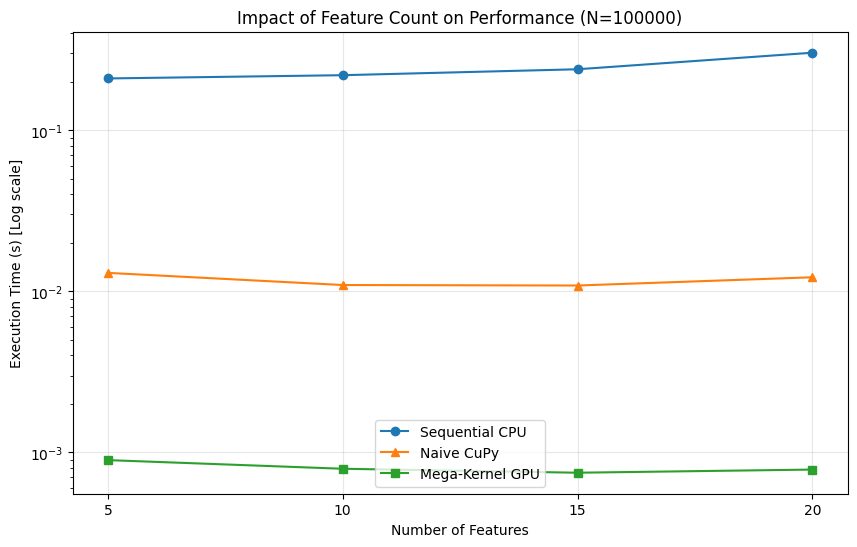

In [16]:
# --- Feature Scaling Analysis ---
# Question: How does the number of features affect CPU vs GPU performance?

if 'cp' in globals() and cp is not None and gpu_available:
    print("\n--- Running Feature Scaling Analysis ([5, 10, 15, 20]) ---")

    feature_counts = [5, 10, 15, 20]
    # Use a fixed N and fixed number of functions for this test to isolate Feature impact
    TEST_N = 100000
    TEST_NUM_FUNCS = 100

    feat_cpu_times = []
    feat_naive_times = []
    feat_gpu_times = []

    # Helper to generate random programs for specific columns
    def generate_random_programs_local(cols, count=100):
        unary = ["sinf", "cosf", "sqrtf"]
        ops = ["+", "-"]
        progs = []
        for _ in range(count):
            def build(depth=4):
                r = rd.randint(0, 100)
                if depth == 0 or r < 30:
                    return f"_{rd.choice(cols)}_"
                elif r < 80:
                    return f"{rd.choice(unary)}({build(depth - 1)})"
                else:
                    return f"({build(depth - 1)}) {rd.choice(ops)} ({build(depth - 1)})"
            progs.append(build())
        return progs

    for n_feat in feature_counts:
        print(f"Testing Features={n_feat}...", end=" ")

        # 1. Generate Data
        current_cols = list("abcdefghijklmnopqrstuvwxyz")[:n_feat]
        x_temp = np.random.rand(TEST_N, n_feat)
        df_temp = pd.DataFrame(x_temp, columns=current_cols)
        df_temp["y"] = np.random.rand(TEST_N)

        # 2. Generate Functions compatible with these features
        test_funcs_feat = generate_random_programs_local(current_cols, TEST_NUM_FUNCS)

        # 3. CPU Benchmark
        t0 = time.perf_counter()
        for line in test_funcs_feat:
            l = line.replace("sqrtf", "np.emath.sqrt") # Fix for negative sqrt
            for u in ["sinf", "cosf", "tanf", "expf"]:
                l = l.replace(u, f"np.{u[:-1]}")
            for c in current_cols:
                l = l.replace(f"_{c}_", f"(df_temp[\"{c}\"].values)")
            try:
                eval(l)
            except: pass
        t_cpu = time.perf_counter() - t0
        feat_cpu_times.append(t_cpu)

        # 4. Naive CuPy Benchmark
        data_gpu_temp = cp.asarray(df_temp[current_cols].values, order='F', dtype=cp.float32)
        y_gpu_temp = cp.asarray(df_temp['y'].values, dtype=cp.float32)

        # Helper for eval to handle sqrtf safely
        def p_sqrt(x): return cp.sqrt(cp.abs(x))

        cp.cuda.Stream.null.synchronize()
        t0 = time.perf_counter()
        for line in test_funcs_feat:
            # Use p_sqrt helper instead of broken string replacement
            l = line.replace("sqrtf", "p_sqrt")
            for u in ["sinf", "cosf", "tanf", "expf"]:
                l = l.replace(u, f"cp.{u[:-1]}")
            for i, c in enumerate(current_cols):
                l = l.replace(f"_{c}_", f"data_gpu_temp[:, {i}]")
            try:
                eval(l)
            except: pass
        cp.cuda.Stream.null.synchronize()
        t_naive = time.perf_counter() - t0
        feat_naive_times.append(t_naive)

        # 5. Mega-Kernel GPU Benchmark
        scores_temp = cp.zeros(len(test_funcs_feat), dtype=cp.float32)

        # Transpile
        transpiled_feat = []
        for f in test_funcs_feat:
            line = f
            for i, c in enumerate(current_cols):
                line = line.replace(f"_{c}_", f"data[idx + {i} * n_rows]")
            line = line.replace("sqrtf", "p_sqrtf")
            transpiled_feat.append(line)

        # Compile (using BATCH_SIZE from earlier)
        batches_feat = [transpiled_feat[i:i + BATCH_SIZE] for i in range(0, len(transpiled_feat), BATCH_SIZE)]
        kernels_feat = []
        for batch_idx, batch in enumerate(batches_feat):
            cases_code = "".join([f"case {i}: y_pred = {code}; break;\n" for i, code in enumerate(batch)])
            code = kernel_code_template.replace("PLACEHOLDER_CASES", cases_code).replace("BLOCK_OFFSET", str(batch_idx * BATCH_SIZE))
            k = cp.RawKernel(code, 'evaluate_population')
            k.compile()
            kernels_feat.append((k, len(batch)))

        # Execute
        cp.cuda.Stream.null.synchronize()
        t0 = time.perf_counter()
        for k, l in kernels_feat:
            k((1, l), (256,), (data_gpu_temp, y_gpu_temp, scores_temp, TEST_N))
        cp.cuda.Stream.null.synchronize()
        t_gpu = time.perf_counter() - t0
        feat_gpu_times.append(t_gpu)

        print(f"CPU: {t_cpu:.4e}s, Naive: {t_naive:.4e}s, Mega: {t_gpu:.4e}s")

    # Plot Feature Scaling
    plt.figure(figsize=(10, 6))
    plt.plot(feature_counts, feat_cpu_times, marker='o', label='Sequential CPU')
    plt.plot(feature_counts, feat_naive_times, marker='^', label='Naive CuPy')
    plt.plot(feature_counts, feat_gpu_times, marker='s', label='Mega-Kernel GPU')
    plt.xlabel('Number of Features')
    plt.ylabel('Execution Time (s) [Log scale]')
    plt.yscale('log')
    plt.title(f'Impact of Feature Count on Performance (N={TEST_N})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(feature_counts)

    FEAT_PLOT_PATH = os.path.join(DATA_DIR, 'feature_scaling_plot.png')
    plt.savefig(FEAT_PLOT_PATH)
    print(f"Feature scaling plot saved to: {FEAT_PLOT_PATH}")
    plt.show()
else:
    print("Skipping Feature Scaling Analysis: GPU unavailable.")
